# Настройка

In [ ]:
!pip install -q bigartm10

     |████████████████████████████████| 2.0MB 12.5MB/s 


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import artm
import IPython.display #needed to render in notebook
import pydotplus #needed to convert dot format to png
from collections import deque, defaultdict
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gDrivePath = "/content/drive/My Drive/M1P/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# НОМЕР ДЕРЕВА С КОТОРЫМ РАБОТАЕМ
l = 0

# Выделяем N-граммы

In [ ]:
ngramm = pd.read_csv(gDrivePath + '/data/wiki_ngrammed.csv' )#, usecols=[0,2])
ngramm.rename(dict(zip(ngramm.columns, ['N', 'Text', 'N_gr'])), axis=1, inplace=True)
print(ngramm.shape)
ngramm.head()

(9565, 3)


,N,Text,N_gr
0,761393,Дискретное пространство\n\nДискре́тное простра...,дискретный пространство дискре тной простр_нст...
1,52789,Теорема Дини\n\nТеорема Ди́ни о равномерной сх...,теорема диня теорема равномерный_сходимость по...
2,6759811,Граф Аполлония\n\nГраф Аполлония — неориентиро...,граф_аполлоний граф_аполлоний неориентированны...
3,8081403,Криптосистема Бонеха — Го — Ниссима\n\nКриптос...,криптосистема бонех ниссим криптосистема бонех...
4,1234825,Информационное множество\n\nИнформационное мно...,информационный множество информационный множес...


In [ ]:
ngramm.dropna(inplace=True)
ngramm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9503 entries, 0 to 9564
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   N       9503 non-null   int64 
 1   Text    9503 non-null   object
 2   N_gr    9503 non-null   object
dtypes: int64(1), object(2)
memory usage: 297.0+ KB


In [ ]:
ngramm[ngramm['N_gr'].isna()].N.values

array([  47232,   47295,   47179,   47171,   47248,    4854,   47176,
       4355761, 3686366,   47174,  680236,   47268,   47218,  243521,
         47225,   47191,   47278,   47233,   47275,   47255,  680305,
        680277, 4355751,  680291,  680269,  680214,  680273,   47182,
       2227777,   47241,   47166,   47184,   47267,   47167,   47161,
         47175,   47296,   47215,  680206,   47192,   47293,   47195,
        680267,   47181,   47222,   47205,   47198,   47302,   47172,
       3707636,   47165,   47173, 3712464,   47269,   47196,   47160,
       1120143,   47207,   47277,   47217,   47272,   47265])

In [ ]:
def select_bm(s):
    words = str(s).split()
    res = ['', '']
    for word in words:
        if '_' in word:
            res[0] += word + ' '
        else:
            res[1] += word + ' '
    return res


ngramm['N_gr'] = ngramm['N_gr'].apply(select_bm)

In [ ]:
ngramm.head()

,N,Text,N_gr
0,761393,Дискретное пространство\n\nДискре́тное простра...,[простр_нство область_математика некоторый_смы...
1,52789,Теорема Дини\n\nТеорема Ди́ни о равномерной сх...,[равномерный_сходимость функция_formula компак...
2,6759811,Граф Аполлония\n\nГраф Аполлония — неориентиро...,[граф_аполлоний граф_аполлоний неориентированн...
3,8081403,Криптосистема Бонеха — Го — Ниссима\n\nКриптос...,[конечный_группа эллиптический_кривая позволят...
4,1234825,Информационное множество\n\nИнформационное мно...,[теория_игра игра_игра содержимый_элемент прот...


# Вычленение только нужных статей

In [ ]:
with open(gDrivePath + '/data/needed_articles-1.bin', 'rb') as f:
    needed1 = pickle.load(f)
with open(gDrivePath + '/data/needed_articles-2.bin', 'rb') as f:
    needed2 = pickle.load(f)
need1 = pd.DataFrame(needed1, columns=['Name', 'N'])
need2 = pd.DataFrame(needed2, columns=['Name', 'N'])
need = pd.concat([need2, need1]).drop_duplicates().reset_index(drop=True)
print(len(need))
need.head()

9580


,Name,N
0,Гамма-сходимость,5917575
1,Геометрический_центр,6989273
2,Задача_о_порядке_перемножения_матриц,1278010
3,Выпуклое_сопряжение,7860121
4,Вариационное_исчисление,68680


In [ ]:
with open(gDrivePath + '/data/needed_articles-2.bin', 'rb') as f:
    needed = pickle.load(f)
need = pd.DataFrame(needed, columns=['Name', 'N'])
print(len(need))
need.head()

425


,Name,N
0,Упаковка_кругов_в_правильном_треугольнике,7036045
1,Минимальная_поверхность,172269
2,Метод_наименьших_модулей,2573587
3,Куст_событий,2247369
4,Байесовская_сеть,662368


In [ ]:
df = pd.read_csv(gDrivePath + '/data/all_articles.csv')
df.rename(dict(zip(df.columns, ['N', 'Text', 'Clean_text'])), axis=1, inplace=True)
df.head()

,N,Text,Clean_text
0,708071,Глазомер\n\nГлазоме́р — способность определять...,глазомер глазома способность определять рассто...
1,761393,Дискретное пространство\n\nДискре́тное простра...,дискретный пространство дискре тной простр нст...
2,7474856,Pterygoplichthys pardalis\n\nPterygoplichthys ...,pterygoplichthys pardalis pterygoplichthys par...
3,52789,Теорема Дини\n\nТеорема Ди́ни о равномерной сх...,теорема диня теорема ди равномерный сходимость...
4,6759811,Граф Аполлония\n\nГраф Аполлония — неориентиро...,граф аполлоний граф аполлоний неориентированны...


In [ ]:
temp = pd.merge(df, need, on = 'N', how='inner')
print(len(temp))
temp.head()

425


,N,Text,Clean_text,Name
0,3760340,Коэффициент Сёренсена\n\nМера Сёренсена — бина...,коэффициент сёренсена мера сёренсена бинарный ...,Коэффициент_Сёренсена
1,908756,Преобразование Лежандра\n\nПреобразование Лежа...,преобразование лежандра преобразование лежандр...,Преобразование_Лежандра
2,21855,"Выпуклая функция\n\nВыпуклая функция (""выпукла...",выпуклый функция выпуклый функция выпуклый вни...,Выпуклая_функция
3,7201977,Процессор машинного зрения\n\nПроцессор машинн...,процессор машинный зрение процессор машинный з...,Процессор_машинного_зрения
4,7044884,Плотная упаковка равных сфер\n\nПлотная упаков...,плотный упаковка равный сфера плотный упаковка...,Плотная_упаковка_равных_сфер


In [ ]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 425 entries, 0 to 424
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   N           425 non-null    int64 
 1   Text        425 non-null    object
 2   Clean_text  425 non-null    object
 3   Name        425 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.6+ KB


In [ ]:
temp[temp['Clean_text'].isna()]

,N,Text,Clean_text,Name
1467,47149,5 (число)\n\n\n,NaN,5_(число)
3610,47148,4 (число)\n\n\n,NaN,4_(число)
5093,42634,3 (число)\n\n\n\n,NaN,3_(число)
6166,47154,10 (число)\n\n,NaN,10_(число)
7088,47153,9 (число)\n\n\n,NaN,9_(число)
9221,47150,6 (число)\n\n,NaN,6_(число)


with open(gDrivePath + '/data/needed_articles-1.bin', 'wb') as f:
    pickle.dump(needed, f)

In [ ]:
temp.dropna(inplace=True)

In [ ]:
temp.to_csv(gDrivePath + '/data/articles_2.csv')

# В vowpal_wabbit формат

In [ ]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9580 entries, 0 to 9579
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   N           9580 non-null   int64 
 1   Text        9580 non-null   object
 2   Clean_text  9580 non-null   object
 3   Name        9580 non-null   object
dtypes: int64(1), object(3)
memory usage: 374.2+ KB


In [ ]:
vw = temp.apply(lambda x: str(x['N']) + ' |text ' + x['Clean_text'], axis = 1)
print(len(vw))
vw.head()

9580


0    761393 |text дискретный пространство дискре тн...
1    52789 |text теорема диня теорема ди равномерны...
2    6759811 |text граф аполлоний граф аполлоний не...
3    8081403 |text криптосистема бонех ниссим крипт...
4    1234825 |text информационный множество информа...
dtype: object

In [ ]:
vw = ngramm.apply(lambda x: str(x['N']) + ' |words ' + x['N_gr'][1] + '|bigrams ' + x['N_gr'][0], axis = 1)
print(len(vw))
vw[0]

9503


'761393 |words дискретный пространство дискре тной топология смежный пространство изолировать дискре тной трика дискре тный метереть ческим топология индуцировать дискретный метрика дискретный метрика дискретный порождать дискретный топология |bigrams простр_нство область_математика некоторый_смысл formula_называться пространство_называться простр_нство обратный_неверный '

In [ ]:
# with open(gDrivePath + '/data/vw_art_0.txt', 'w') as fout:
#     for line in vw:
#         fout.write(line + '\n')

# Строим тематические модели

In [ ]:
# batch_vectorizer = artm.BatchVectorizer(data_path=gDrivePath + '/data/vw_art_0.txt', data_format='vowpal_wabbit', collection_name='vw_art_0', target_folder=gDrivePath + '/data/batches_0')

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path=gDrivePath + f'/data/batches_{l}', data_format = 'batches')

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary

artm.Dictionary(name=daf2d835-7d18-4e7c-9168-34f94c1a7d60, num_entries=89070)

In [ ]:
def print_topic_top_words(model, metric):
    for topic_name in model.topic_names:
      print(topic_name + ': '),
      try:
          print(", ".join(model.score_tracker[metric].last_tokens[topic_name]))
      except:
          print("Not enough unigrams in a topic")
          print()

## PLSA

In [ ]:
model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(14)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       cache_theta=True, reuse_theta=True, theta_columns_naming='title')

In [ ]:
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScoreP', class_id='text', eps=1e-5))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScoreP', eps=8e-4))
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScoreP', num_tokens=15, class_id='text'))

In [ ]:
model_plsa.initialize(dictionary=dictionary)

In [ ]:
%%time
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

CPU times: user 2min 42s, sys: 1.8 s, total: 2min 44s
Wall time: 1min 32s


In [ ]:
print_topic_top_words(model_plsa, 'TopTokensScoreP')

topic_0: 
матрица, вектор, пространство, система, функция, оператор, линейный, операция, преобразование, векторный, вид, произведение, случай, базис, производный
topic_1: 
треугольник, угол, окружность, сторона, игра, площадь, равный, прямая, длина, игрок, единица, теорема, центр, фигура, расстояние
topic_2: 
система, решение, метод, управление, исследование, область, процесс, задача, сеть, искусственный, интеллект, использовать, знание, модель, университет
topic_3: 
сигнал, частота, изображение, фильтр, система, код, напряжение, использоваться, входной, цифровой, использовать, канал, преобразование, метод, схема
topic_4: 
система, пользователь, использовать, сеть, компания, версия, проект, использование, программа, позволять, файл, возможность, блок, программный, карта
topic_5: 
группа, множество, элемент, пространство, formula_1, formula_2, кольцо, называться, отображение, многообразие, теорема, formula_3, конечный, поль, класс
topic_6: 
буква, шифр, текст, машина, книга, использоват

In [ ]:
print(model_plsa.score_tracker['SparsityPhiScoreP'].last_value)
print(model_plsa.score_tracker['SparsityThetaScoreP'].last_value)

0.9310365915298462
0.7407768964767456


In [ ]:
F = model_plsa.get_theta()
F.to_csv(gDrivePath+f'/data/plsa_theta.csv')

## LDA

In [ ]:
model_lda = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(14)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.1),
                                     artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1)],
                       cache_theta=True, reuse_theta=True, theta_columns_naming='title')

In [ ]:
model_lda.scores.add(artm.SparsityPhiScore(name='SparsityPhiScoreL', class_id='text', eps=1e-5))
model_lda.scores.add(artm.SparsityThetaScore(name='SparsityThetaScoreL', eps=1e-5))
model_lda.scores.add(artm.TopTokensScore(name='TopTokensScoreL', num_tokens=15, class_id='text'))
model_lda.initialize(dictionary=dictionary)

In [ ]:
%%time
model_lda.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

CPU times: user 2min 49s, sys: 3.22 s, total: 2min 52s
Wall time: 1min 39s


In [ ]:
print(model_lda.score_tracker['SparsityPhiScoreL'].last_value)
print(model_lda.score_tracker['SparsityThetaScoreL'].last_value)
theta0 = model_lda.get_theta()
print('Num zeros col in theta: ', sum([(theta0[i] == 0).all() for i in theta0.columns]))

0.9297903776168823
0.7641813158988953
Num zeros col in theta:  0


In [ ]:
print_topic_top_words(model_lda, 'TopTokensScoreL')

topic_0: 
функция, пространство, система, вектор, матрица, оператор, линейный, уравнение, вид, координата, случай, векторный, производный, операция, называться
topic_1: 
угол, треугольник, сторона, равный, игра, длина, площадь, теорема, единица, окружность, игрок, координата, геометрия, век, круг
topic_2: 
система, решение, метод, управление, задача, модель, процесс, область, исследование, обучение, университет, сеть, использовать, анализ, цель
topic_3: 
сигнал, частота, фильтр, изображение, система, значение, напряжение, использоваться, схема, цифровой, код, входной, использовать, характеристика, ток
topic_4: 
система, пользователь, блок, сеть, использовать, компания, версия, код, проект, транзакция, криптовалюта, использование, позволять, файл, возможность
topic_5: 
группа, множество, элемент, formula_1, пространство, теорема, formula_2, называться, кольцо, formula_3, конечный, простой, существовать, formula_4, случай
topic_6: 
буква, шифр, текст, машина, книга, символ, использоватьс

In [ ]:
F = model_lda.get_theta()
F.to_csv(gDrivePath+'/data/lda_theta.csv')

## ARTM

In [ ]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(14)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.1),
                                     artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1)],
                       cache_theta=True, reuse_theta=True, theta_columns_naming='title')

In [ ]:
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=-50e4))

In [ ]:
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScoreA', class_id='text', eps=1e-5))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScoreA', eps=1e-5))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScoreA', num_tokens=15, class_id='text'))

In [ ]:
model_artm.initialize(dictionary=dictionary)

In [ ]:
%%time
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

CPU times: user 2min 50s, sys: 3.11 s, total: 2min 53s
Wall time: 1min 41s


In [ ]:
print(model_artm.score_tracker['SparsityPhiScoreA'].last_value)
print(model_artm.score_tracker['SparsityThetaScoreA'].last_value)
theta0 = model_artm.get_theta()
print('Num zeros col in theta: ', sum([(theta0[i] == 0).all() for i in theta0.columns]))

0.9303942322731018
0.7657247185707092
Num zeros col in theta:  0


In [ ]:
print_topic_top_words(model_artm, 'TopTokensScoreA')

topic_0: 
функция, система, пространство, вектор, матрица, оператор, уравнение, линейный, вид, случай, координата, называться, векторный, производный, formula_1
topic_1: 
треугольник, угол, сторона, равный, система, теорема, длина, игра, единица, площадь, задача, окружность, игрок, координата, геометрия
topic_2: 
система, решение, метод, управление, задача, модель, процесс, область, исследование, университет, обучение, анализ, сеть, цель, использовать
topic_3: 
сигнал, система, частота, фильтр, изображение, значение, функция, использовать, использоваться, напряжение, метод, схема, входной, цифровой, код
topic_4: 
система, использовать, функция, пользователь, блок, сеть, компания, код, версия, использование, позволять, использоваться, проект, транзакция, криптовалюта
topic_5: 
группа, множество, элемент, formula_1, пространство, теорема, formula_2, называться, кольцо, formula_3, простой, случай, конечный, существовать, formula_4
topic_6: 
буква, шифр, текст, использовать, использоваться

In [ ]:
F = model_artm.get_theta()
F.to_csv(gDrivePath+f'/data/artm_theta.csv')

## Иерархическая

In [ ]:
hier = artm.hARTM(scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary)],
                  cache_theta=True, reuse_theta=True, theta_columns_naming='title')

In [ ]:
level0 = hier.add_level(num_topics=14)
level0.initialize(dictionary)
level0.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi0', tau=5e4))
level0.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.05))
level0.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))

level0.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore0', class_id='text', eps=1e-5))
level0.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore0', eps=1e-5))
%time level0.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 1min 5s, sys: 1.11 s, total: 1min 6s
Wall time: 38.5 s


In [ ]:
print('level0')
print('SparsityPhi: ', level0.score_tracker['SparsityPhiScore0'].last_value)
print('SparsityTheta: ', level0.score_tracker['SparsityThetaScore0'].last_value)
theta0 = level0.get_theta()
print('Num zeros col in theta: ', sum([(theta0[i] == 0).all() for i in theta0.columns]))

level0
SparsityPhi:  0.9300758838653564
SparsityTheta:  0.7351476550102234
Num zeros col in theta:  0


In [ ]:
%time level1 = hier.add_level(num_topics=50, topic_names=['child_topic_' + str(i) for i in range(50)], parent_level_weight=1)
level1.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore1', class_id='text', eps=1e-5))
level1.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore1', eps=1e-5))
level1.scores.add(artm.TopTokensScore(name='TopTokensScore1', num_tokens=15, class_id='text'))
level1.regularizers.add(artm.HierarchySparsingThetaRegularizer(name="HierSp", tau=2),overwrite=True)
level1.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),overwrite=True)

CPU times: user 7.39 s, sys: 426 ms, total: 7.81 s
Wall time: 7.5 s


In [ ]:
level1.initialize(dictionary)
level1.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.01),overwrite=True)
level1.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi1', tau=15e4),overwrite=True)
%time level1.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

CPU times: user 2min 3s, sys: 2.32 s, total: 2min 5s
Wall time: 1min 15s


In [ ]:
print('level1')
print('SparsityPhi: ', level1.score_tracker['SparsityPhiScore1'].last_value)
print('SparsityTheta: ', level1.score_tracker['SparsityThetaScore1'].last_value)
theta1 = level1.get_theta()
print('Num zeros col in theta: ',sum([(theta1[i] == 0).all() for i in theta1.columns]))

level1
SparsityPhi:  0.945278525352478
SparsityTheta:  0.870569109916687
Num zeros col in theta:  0


In [ ]:
print_topic_top_words(level1, 'TopTokensScore1')

child_topic_0: 
игра, игрок, теория, стратегия, модель, группа, равновесие, экономический, анализ, тип, экономика, решение, случай, выигрыш, сортировка
child_topic_1: 
система, цифра, век, единица, использоваться, книга, буква, сторона, мера, угол, счисление, большой, треугольник, использовать, счёт
child_topic_2: 
кривая, угол, кривизна, плоскость, сфера, поверхность, линия, расстояние, направление, прямая, геометрия, ося, длина, плоский, окружность
child_topic_3: 
язык, правило, логический, тип, аксиома, логика, парадокс, множество, выражение, понятие, вывод, анализ, формальный, утверждение, отношение
child_topic_4: 
шифр, машина, текст, буква, энигма, ротор, автомат, зашифровать, немецкий, криптография, шифровальный, шифрование, война, клеточный, использоваться
child_topic_5: 
ставка, процентный, финансовый, анализ, оценка, риска, доходность, расчёт, показатель, риск, стоимость, уровень, денежный, процент, инструмент
child_topic_6: 
элемент, formula_1, кольцо, простой, последователь

In [ ]:
theta0.to_csv(gDrivePath+'/data/hier_theta_0.csv')
theta1.to_csv(gDrivePath+'/data/hier_theta_1.csv')
psi = level1.get_psi()
psi.to_csv(gDrivePath+'/data/hier_psi_1.csv')

In [ ]:
with open(gDrivePath+'/data/phi1.batch', 'w') as f:
    f.write('phi1.batch')

# Считаем метрику

In [ ]:
ngramm = pd.read_csv(gDrivePath + '/data/wiki_ngrammed.csv' )#, usecols=[0,2])
ngramm.rename(dict(zip(ngramm.columns, ['N', 'Text', 'N_gr'])), axis=1, inplace=True)
articles = pickle.load(open(gDrivePath+'data/needed_articles-2.bin', 'rb'))
articles = list(articles)
bol = [(elem[1] not in ngramm[ngramm['N_gr'].isna()].N.values) for elem in articles] #and (str(elem[1]) not in del_a)
articles = np.array(articles)
articles = list(articles[bol])
print(len(articles))

425


In [ ]:
class AdjacencyMatrix:
    
    def __init__(self, tree):
        self.tree = tree
        self.vertex_ids = list(tree.keys())
        self.num_vertexes = len(tree)
        self.adj = {}
        self.mapping = {}
        
        self._build_mapping()
        self._bfs()
        
    def _bfs(self):
        for vertex in self.vertex_ids:
            queue = deque()
            used = set()
            queue.append((vertex, 0))
            while len(queue) > 0:
                v, dist = queue.popleft()
                self.adj[(vertex, v)] = dist
                
                used.add(v)
                desc = self.tree[v]
                
                for u in desc:
                    if u not in used and u[0] in self.tree:
                        queue.append((u[0], dist + 1))
                        
    def _build_mapping(self):
        for vertex in self.vertex_ids:
            desc = self.tree[vertex]
            for u in desc:
                for doc in u:
                    self.mapping[doc] = u[0]
            
    
    def get(self, doc1, doc2):
        vertex1 = self.mapping[doc1]
        vertex2 = self.mapping[doc2]
        if ((vertex1, vertex2) not in self.adj) or (self.adj[(vertex1, vertex2)] == 0):
            return 0
        return 1 / self.adj[(vertex1, vertex2)]

## Обрабатываем википедийные деревья

In [ ]:
with open(gDrivePath + '/data/validation.bin', 'rb') as f:
    trees = pickle.load(f)

In [ ]:
[len(tree) for tree in trees]

[590, 34]

In [ ]:
def convert(new_tree, tree, pred):
    S = tuple(str(elem[1]) for elem in tree[pred]['articles'])
    if len(S) != 0:
        res = [convert(new_tree, tree, child[0]) for child in tree[pred]['categories']]
        if len(res) != 0:
            new_tree[str(S[0])] = res
    return S

In [ ]:
l = 1
wiki = {}
wiki[0] = [convert(wiki, trees[l], [*(trees[l].keys())][0])]

In [ ]:
matrix_wiki = AdjacencyMatrix(wiki)
mx_wiki = np.zeros((len(articles), len(articles)))
for i in tqdm(range(len(articles))):
    for j in range(len(articles)):
        doc1 = str(articles[i][1])
        doc2 = str(articles[j][1])
        mx_wiki[i, j] = matrix_wiki.get(doc1, doc2)

100%|██████████| 425/425 [00:00<00:00, 1267.54it/s]


In [ ]:
with open(gDrivePath + 'data/mx_wiki.pickle', 'wb') as f:
    pickle.dump(mx_wiki, f)

## Считаем метрику

In [ ]:
def metric(graph):
    matrix = AdjacencyMatrix(graph)
    mx = np.zeros((len(articles), len(articles)))
    for i in range(len(articles)):
        for j in range(len(articles)):
            doc1 = str(articles[i][1])
            doc2 = str(articles[j][1])
            mx[i, j] = matrix.get(doc1, doc2)
    return np.sum(np.square(mx - mx_wiki))#/(len(mx)**2)

In [ ]:
with open(gDrivePath + 'data/mx_wiki.pickle', 'rb') as f:
    mx_wiki = pickle.load(f)
# names = ['artm_bm_t0_k0_n1.pickle']
# for name in names:
#     print(name, metric(pickle.load(open(gDrivePath+'/res/'+name, 'rb'))))

In [ ]:
metric(graph)

31.600040582591795

# Строим граф

τ , which defines the minimum overlap between two equivalent documents, and κ, which defines the maximum difference of their generality scores

In [ ]:
def g(i):
    return - np.sum(F[i] * np.log(F[i]))

def o(i, j):
    if (i, j) in O.keys():
        return O[(i, j)]
    elif (j, i) in O.keys():
        return O[(j, i)]
    else:
        O[(i, j)] = F[i]@F[j] / (F[i]@F[i]+F[j]@F[j]-F[i]@F[j])
        return O[(i, j)]

In [ ]:
def DynOrder(D_f, pred_f, graph, t_f, k_f):
    gq = deque([(D_f, pred_f, t_f, k_f)])
    while len(gq)>0:
        D, pred, t, k = gq.popleft()
        if pred not in graph.keys():
            graph[pred] = []
        while len(D) > 0:
            d = D.pop()
            S = {d[0]}
            if len(D) != 0:
                i = -1
                d_j = D[i]
                while (o(d[0], d_j[0]) > t) and (d[1] < d_j[1] + k):
                    to_add = True
                    for d_i in S:
                        to_add &= (o(d_i, d_j[0]) > t)
                        if not to_add:
                            break
                    if to_add:
                        S.add(d_j[0])
                        D.pop(i)
                        i += 1
                    i -= 1
                    if(-i <= len(D)):
                        d_j = D[i]
                    else:
                        break

            S = tuple(S)
            graph[pred].append(S)

            C = []
            temp = []
            for d_j in D:
                if o(d[0], d_j[0])>0:
                    added = False
                    for clas in C:  # Ищем в какой из уже имеющихся классов добавить
                        to_add = True
                        for elem in clas:
                            to_add &= (o(elem[0], d_j[0])>0)
                        if to_add:
                            added = True
                            clas.append(d_j)
                            break
                    if not added:  # Если не нашли подходящий, то создаём новый
                        C.append([d_j])
                else:
                    temp.append(d_j)
            #print(len(C))
            for clas in C:
                clas.sort(key=lambda kv: kv[1])
                gq.append((clas, S[0], t/n, k))

            D = temp
    return graph

In [ ]:
l = 2
df = pd.read_csv(gDrivePath + f'/data/articles_{l}.csv', index_col=0)
# del_a = set(['7854596', '7696245', '7676738', '7861737', '7737521', '7115595', '7678381', '7739131', '7692453', '7853691', '5591339', '7493499', '7695785', '7503523', '7735746'])
F = pd.read_csv( gDrivePath+'/data/plsa_theta.csv', index_col=0)
F = F[set(df['N'].values.astype(str))]#.difference(del_a)]
print(F.shape)
h_i = sorted([(i, g(i)) for i in F.columns], key=lambda kv: kv[1])
print(h_i[0], h_i[-1])

(14, 425)
('3629547', -0.0) ('3958657', 2.005014787262185)


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Построение графа

In [ ]:
O = {(0,0):0}
t = 0
k = 0
n = 1 
g_i = h_i.copy()
%time graph = DynOrder(g_i, 0, {}, t, k)
print(metric(graph))

CPU times: user 12.1 s, sys: 58.3 ms, total: 12.1 s
Wall time: 12.1 s
13395.88239128129


Подбор параметров

In [ ]:
O = {(0,0):0}
graph = {}
for k in np.arange(0, 1, 0.1):
    g_i = h_i.copy()
    graph = DynOrder(g_i, 0, {}, t, k)
    print(k, metric(graph))

0.0 31.514641732740582
0.1 48.41053849752772
0.2 62.57105040682939
0.30000000000000004 72.90149999999998
0.4 77.29156862745099
0.5 79.05764705882353
0.6000000000000001 91.93431372549018
0.7000000000000001 99.65960784313724
0.8 84.56176470588235
0.9 92.21588235294118


Строим всем скопом

In [ ]:
l = 2
t = 0
k = 0
n = 1
df = pd.read_csv(gDrivePath + f'/data/articles_{l}.csv', index_col=0)
del_a = set(['7854596', '7696245', '7676738', '7861737', '7737521', '7115595', '7678381', '7739131', '7692453', '7853691', '5591339', '7493499', '7695785', '7503523', '7735746'])
names = ['artm_bm_theta', 'artm_theta', 'hier_bm_theta_1', 'plsa_theta', 'lda_theta', 'hier_theta_1']
for name in names:
    F = pd.read_csv( gDrivePath+f'/data/{name}.csv', index_col=0)
    F = F[set(df['N'].values.astype(str)).difference(del_a)]
    g_i = sorted([(i, g(i)) for i in F.columns], key=lambda kv: kv[1])
    O = {(0,0):0}
    %time graph = DynOrder(g_i, 0, {}, t, k)
    print(name, metric(graph))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 5.99 s, sys: 111 ms, total: 6.1 s
Wall time: 5.98 s
artm_bm_theta 13440.603999951743


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 7.39 s, sys: 127 ms, total: 7.52 s
Wall time: 7.35 s
artm_theta 13414.555913914717


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 5.06 s, sys: 85.2 ms, total: 5.14 s
Wall time: 5.04 s
hier_bm_theta_1 13447.500361287914


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 9.79 s, sys: 110 ms, total: 9.9 s
Wall time: 9.77 s
plsa_theta 13395.548717843572


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 6.9 s, sys: 136 ms, total: 7.04 s
Wall time: 6.84 s
lda_theta 13426.40100186185


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 7.48 s, sys: 62.3 ms, total: 7.54 s
Wall time: 7.47 s
hier_theta_1 13393.179245656018


In [ ]:
with open(gDrivePath + f'res/artm_bm_t{t}_k{k}_n{n}.pickle', 'wb') as f:
    pickle.dump(graph, f)

In [ ]:
# PLSA  13393.722736414744 15.2 s
# t = 0 # любое
# k = 0 # любое
# n = 1 # любое

# HIER  13430.070019725119 9.29 s
# t = 0 #любой
# k = 0
# n = 1 # любой

# ARTM  13457.444557724573 7.24 s
# t = 0 # и более
# k = 0 # любое
# n = 1 # и меньше

# HIER with h_entrop  13458.697120906132  6.8 s
# t = 0.1 #любое
# k = 0
# n = 1 #любое

# LDA   13468.027721856224 7.33 s
# t = 0 # любое
# k = 0 # любое
# n = 1 # или меньше(но по времени лучше)

# Строим граф с иерархической энтропией

In [ ]:
theta0 = pd.read_csv(gDrivePath+'/data/hier_theta_0.csv', index_col=0)
theta1 = pd.read_csv(gDrivePath+'/data/hier_theta_1.csv', index_col=0)
psi = pd.read_csv(gDrivePath+'/data/hier_psi_1.csv', index_col=0)

l = 2
df = pd.read_csv(gDrivePath + f'/data/articles_{l}.csv', index_col=0)
del_a = set([])
#del_a = set(['7854596', '7696245', '7676738', '7861737', '7737521', '7115595', '7678381', '7739131', '7692453', '7853691', '5591339', '7493499', '7695785', '7503523', '7735746'])
theta0 = theta0[set(df['N'].values.astype(str)).difference(del_a)]
theta1 = theta1[set(df['N'].values.astype(str)).difference(del_a)]
print(theta0.shape)

(14, 425)


In [ ]:
def g(i): #hierarchcal_enthropy
    enthropy_embedding = -theta1[i] * np.log(theta1[i] + 1e-10)
    conv_matrix = (psi.T * enthropy_embedding).T
    conv = np.sum(conv_matrix, axis=0)
    return np.sum(conv * theta0[i])

O = {(0,0):0}
def o(i, j):
    if (i, j) in O.keys():
        return O[(i, j)]
    elif (j, i) in O.keys():
        return O[(j, i)]
    else:
        O[(i, j)] = theta1[i]@theta1[j] / (theta1[i]@theta1[i]+theta1[j]@theta1[j]-theta1[i]@theta1[j])
        return O[(i, j)]

In [ ]:
h_i = sorted([(i, g(i)) for i in theta0.columns], key=lambda kv: kv[1])
print(h_i[0], h_i[-1], len(h_i))

('7028733', 3.036525849823727e-10) ('3663070', 0.31373792837368625) 425


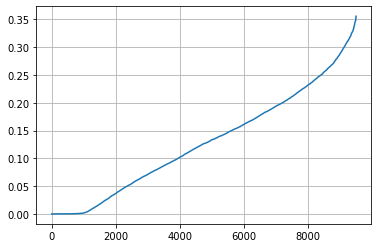

In [ ]:
plt.plot(np.arange(0, 9503, 1), [elem[1] for elem in h_i])
plt.grid(True)

In [ ]:
O = {(0,0):0}
t = 1 #любое
k = 0
n = 1 #любое
g_i = h_i.copy()
%time graph = DynOrder(g_i, 0, {}, t, k)
print(metric(graph))

In [ ]:
O = {(0,0):0}
for n in np.arange(0, 10, 1):
    g_i = h_i.copy()
    graph = DynOrder(g_i, 0, {}, t, k)
    print(t, metric(graph))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in long_scalars


1 13479.667582768123
1 13479.667582768123
1 13479.667582768123
1 13479.667582768123
1 13479.667582768123
1 13479.667582768123
1 13479.667582768123
1 13479.667582768123
1 13479.667582768123
1 13479.667582768123


In [ ]:
with open(gDrivePath + f'res/1_hier_bm_hentrop_t{t}_k{k}_n{n}.pickle', 'wb') as f:
    pickle.dump(graph, f)

# Рисуем граф

In [ ]:
df = pd.read_csv(gDrivePath + f'/data/articles_{l}.csv', index_col=0)

In [ ]:
def dfs(nod, graph):
    q = deque([nod])
    while len(q)>0:
        node = q.popleft()
        s = ''
        for elem in node:
            s += df[df['N'] == int(elem)].Name.values[0]+'\n'
        sgr[1] += f'{node[0]} [label = "{s}"];'
        if node[0] in graph.keys():
            for child in graph[node[0]]:
                q.append(child)
                if len(child)== 0:
                    print(node[0])
                sgr[2] += f'{node[0]} -> {child[0]}; '

In [ ]:
res = ['digraph {node [shape=box]; ', '', '', '};']
for i in range(len(graph[0])):
    sgr = ['digraph {node [shape=box]; ', '', '', '};']
    dfs(graph[0][i], graph)
    res[1] += sgr[1]
    res[2] += sgr[2]
draw_gr = pydotplus.graph_from_dot_data(res[0]+res[1]+res[2]+res[3])
#IPython.display.display(IPython.display.Image(draw_gr.create_png()))
draw_gr.write_pdf('/content/drive/My Drive/M1P/small_plsa.pdf')

True

# Результат

hier_t0.01_k5_n2.pickle$\hspace{12mm}$801627.4967822686$\hspace{5mm}$21 min

hier_t0.01_k0.03_n1.5.pickle$\hspace{3mm}$785630.1767804039$\hspace{5mm}$31 min

plsa_t1_k0.3_n1.3.pickle$\hspace{10mm}$486274.1168592022$\hspace{5mm}$12 min

1_hier_bm_hentrop_t0.1_k0_n1.pickle$\hspace{1mm}$318679.7826782907$\hspace{5mm}$24min

-------------------------------------------------------

artm_t0_k0_n1.pickle$\hspace{30mm}$319071.23070007237$\hspace{5mm}$2h 28min

lda_t1_k0_n1.pickle$\hspace{33mm}$319034.6183065148$\hspace{7mm}$2h 28min

hier_t0_k0_n1.pickle$\hspace{32mm}$318899.3423647155$\hspace{7mm}$1h 8min

hier_hentrop_t0.1_k0_n1.pickle$\hspace{12mm}$318566.68808036606$\hspace{5mm}$38 min

plsa $\hspace{59mm}$ оценочно 317000 за $3*10^8$ min

# Визуализация результатов

In [ ]:
def plot_embeddings(M_reduced, word2Ind, words):
    plt.ylabel('Execution time (min)', fontsize=12)
    plt.xlabel('Score', fontsize=12)
    # plt.xlim((0.07965, 0.08031))
    plt.xlim((0.0035311, 0.0035334))
    plt.grid(True)
    for w in words:
        x, y = M_reduced[word2Ind[w]]
        plt.scatter(x, y, color='red')
        plt.text(x, y, ' '+w, fontsize=10)
    plt.show()

In [ ]:
labels_s = ['hARTM', 'PLSA', 'ARTM with \n bigrams', 'ARTM', 'LDA', 'hARTM with bigrams', 'hARTM with \n Hierarchical Entropy', 'hARTM with \n bigrams and\n Hierarchical Entropy']
res_s = np.array([0.07967388010503, 0.0796879, 0.07995600, 0.0798010, 0.0798715, 0.0799970277, 0.079829554, 0.08018838538])
#res_s *= (410**2)
values_s = list(zip(res_s, [6.96, 10.1, 5.84, 6.91, 6.32, 4.75, 5.71, 2.96]))

In [ ]:
for i, label in enumerate(labels_s):
    print(label.replace('\n', '\\\\') + ' & ' + str(values_s[i][0]) + ' & ' + str(values_s[i][1]) + ' \\\\')

hARTM & 0.07967388010503 & 6.96 \\
PLSA & 0.0796879 & 10.1 \\
ARTM with \\ bigrams & 0.079956 & 5.84 \\
ARTM & 0.079801 & 6.91 \\
LDA & 0.0798715 & 6.32 \\
hARTM with bigrams & 0.0799970277 & 4.75 \\
hARTM with \\ Hierarchical Entropy & 0.079829554 & 5.71 \\
hARTM with \\ bigrams and\\ Hierarchical Entropy & 0.08018838538 & 2.96 \\


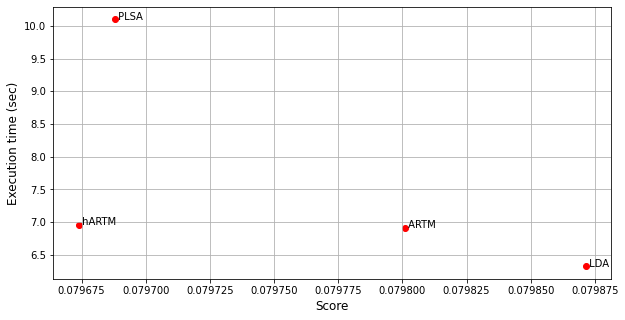

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
words = ['PLSA', 'ARTM', 'LDA', 'hARTM']#labels_s
word2Ind_plot_test = dict(zip(labels_s, np.arange(0, len(labels_s))))
plot_embeddings(values_s, word2Ind_plot_test, words)

Если не выбрасывать 15 статей

In [ ]:
labels_s = ['LDA', 'hARTM with \n Hierarchical Entropy', 'ARTM', 'hARTM', 'PLSA']
res_s = np.array([13443.464755, 13458.69712, 13446.46, 13430.070,  13395.027])
# res_s /= 425**2
values_s = list(zip(res_s, [7.28, 5.49, 6.89, 7.86, 12.5]))

labels_b = ['ARTM with \n bigrams', 'ARTM', 'LDA', 'hARTM with bigrams', 'hARTM',\
            'hARTM with bigrams \n and Hierarchical Entropy', 'hARTM with \n Hierarchical Entropy']
res_b = np.array([319125, 319071, 319034, 318970, 318899, 318667, 318566, 317000])
res_b = res_b/(9503**2)
values_b = list(zip(res_b, [65, 148, 148, 42, 68, 22, 38]))

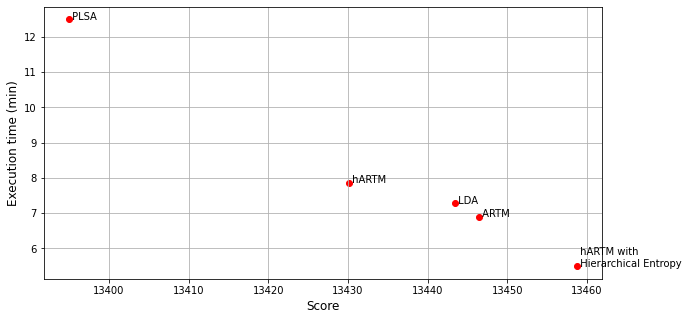

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
words = labels_s
word2Ind_plot_test = dict(zip(words, np.arange(0, len(words))))
plot_embeddings(values_s, word2Ind_plot_test, words)

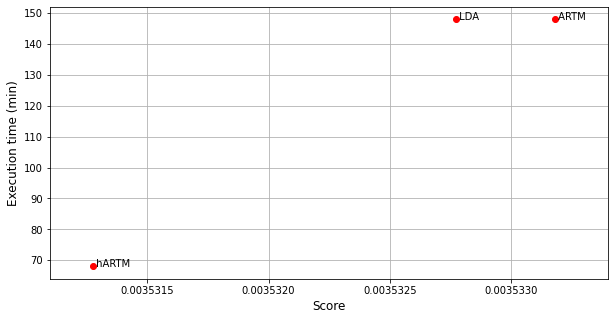

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
words = ['ARTM', 'LDA', 'hARTM']#labels_b
word2Ind_plot_test = dict(zip(labels_b, np.arange(0, len(labels_b))))
plot_embeddings(values_b, word2Ind_plot_test, words)

# Архив

In [ ]:
def Jaccard(tuple_1, tuple_2):
    set_1 = set(tuple_1)
    set_2 = set(tuple_2)
    return len(set_1 & set_2) / len(set_1 | set_2)

In [ ]:
def get_metric(root_w, root_g):
    q = deque([(root_w, root_g)])
    res = 0
    while len(q)>0:
        current = q.popleft()
        root_wiki = current[0]
        root_graph = current[1]
        not_mapped_elem = np.ones(len(wiki[root_wiki]), dtype=bool)
        for elem in graph[root_graph]:                                           #graph
            jac = []
            for j, elem_wiki in enumerate(wiki[root_wiki]):
                jac.append(Jaccard(elem, elem_wiki) if not_mapped_elem[j] else -1)
            i = np.argmax(jac)
            max_jac_val = jac[i]
            if max_jac_val != 0:
                not_mapped_elem[i] = False
                new_root_wiki = wiki[root_wiki][i][0]
                res += max_jac_val/len(trees[l])
                if (new_root_wiki in wiki.keys()) and (elem[0] in graph.keys()): #graph
                    q.append((new_root_wiki, elem[0]))
    if res != 0:
        with open(gDrivePath + f'/res/{res}_graph_{l}_t{t}_k{k}.pickle', 'wb') as f:
            pickle.dump(graph, f)
    return res

In [ ]:
metr = get_metric(0, 0)

0

In [ ]:
res = ['digraph {node [shape=box]; ', '', '', '};']
for i in range(len(graph['0'])):
    sgr = ['digraph {node [shape=box]; ', '', '', '};']
    dfs(graph['0'][i], graph)
    res[1] += sgr[1]
    res[2] += sgr[2]
str_g = res[0]+res[1]+res[2]+res[3]
draw_gr = pydotplus.graph_from_dot_data(str_g.encode('utf-8', errors='ignore'))
draw_gr.write_pdf('/content/drive/My Drive/M1P/hier_2.pdf')

True

In [ ]:
y = sorted([g(i) for i in tqdm(theta0.columns)])

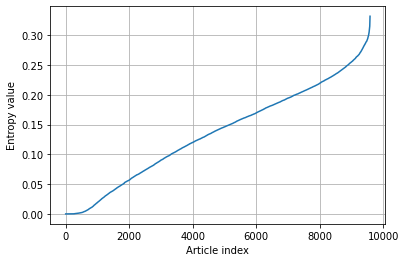

In [ ]:
plt.plot(np.arange(0, 9580, 1), y)
plt.ylabel('Entropy value')
plt.xlabel('Article index')
plt.grid(True)

In [ ]:
res = np.array([13468, 17023, 16448, 18277, 16555, 16214, 19255, 18287, 18270])
res/(425**2)

array([0.07456332, 0.09424498, 0.09106159, 0.10118754, 0.09165398,
       0.08976609, 0.10660208, 0.10124291, 0.10114879])

In [ ]:
res = np.array([13393.72, 13430.0700, 13457.44, 13458.697,  13468.027])
res/(425**2)

array([0.07415208, 0.07435333, 0.07450486, 0.07451182, 0.07456347])

In [ ]:
res = np.array([319125, 319071, 319034, 318970, 318899, 318667, 318566, 317000])
res/(9503**2)

array([0.00353378, 0.00353318, 0.00353277, 0.00353206, 0.00353128,
       0.00352871, 0.00352759, 0.00351025])

In [ ]:
# F.rename(columns=dict(zip(sorted(F.columns), sorted(df['N']))), inplace=True)

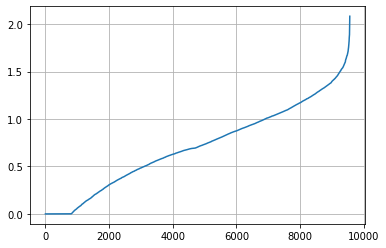

In [ ]:
plt.plot(np.arange(0, 9565, 1), sorted([i[1] for i in h_i]))
plt.grid(True)